## Context: Loss Function Investigation for InnerPiSSA

first see README.md for paper setup

### The Core Problem

We're investigating why certain approaches work for adapter init but not for loss (and vice versa).

**Init selection results:**
- `cho_var_snorm` (workspace variance, S-normalized): **167.85** ✓
- `diff_var_snorm` (cho-rej difference variance): **13.00** ✗

Yet the loss still uses the diff direction. Is this inconsistent?

### Key Insight: The Diff IS De-biased

```python
h_cho = [shared_processing] + [planning_for_honest]      # 95% + 5%
h_rej = [shared_processing] + [planning_for_dishonest]   # 95% + 5%
diff  = [planning_for_honest] - [planning_for_dishonest] # Just the 5%
```

The shared processing (which carries S-bias from pretraining) cancels. The diff isolates the planning signal, which:
- Is small in magnitude (why diff_var fails for init — needs magnitude to rank)
- May live in low-S dimensions (orthogonal to pretrain priorities)
- Is the actual task-relevant information

### The Asymmetry Between Adapter and Loss

**Adapter (forward pass):**
- Sees one sample at a time
- Transforms: `h_out = h_in @ (W_base + ΔW)`
- Doesn't know if this sample is cho or rej

**Loss:**
- Sees pairs
- Computes `(cho - rej) · pref_dir`
- Rewards separation along a fixed direction

This may explain why diff works for loss (direction matters, normalized anyway) but fails for init (magnitude needed to rank dimensions).

### S-Space Projection Options

Given SVD: `W = U @ diag(S) @ V^T`

| Formula | What it does | Interpretation |
|---------|--------------|----------------|
| `h @ V` | Project to S-coordinates | Orthonormal rotation, all dims equal |
| `h @ V * S` | S-weighted coordinates | High-S dims amplified (pretrained importance) |
| `h @ V / S` | S-normalized coordinates | High-S dims suppressed (removes pretrain bias) |
| `h @ V * sqrt(S)` | Symmetric weighting | Mahalanobis-like, used in PiSSA |

**Current inconsistency:**
- Init uses `/ S` (snorm) — removes pretrain bias
- Loss uses `@ V` only — pretrain bias still present in gradients


In [31]:
from transformers import AutoModelForCausalLM, AutoTokenizer
import torch
import numpy as np
import pandas as pd
import os, sys, re, json
from loguru import logger
import torch.nn.functional as F
from pathlib import Path
from einops import rearrange, reduce, repeat

logger.remove()
logger.remove()
logger.add(sys.stderr, level="INFO", format=

SyntaxError: incomplete input (4200892035.py, line 13)

In [ ]:
model_id =  "Qwen/Qwen3-0.6B"
model = AutoModelForCausalLM.from_pretrained(
    model_id,
    device_map="cpu",
)
tokenizer = AutoTokenizer.from_pretrained(model_id)

In [ ]:
# Load proper contrastive dataset
import sys
sys.path.insert(0, str(Path('/media/wassname/SGIronWolf/projects5/2025/llm_moral_lb_v2/repeng')))

from ipissa.config import TrainingConfig
from ipissa.train.data import create_train_dataset

config = TrainingConfig()
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "left"  # left pad so last token is at same position

train_honest, train_dataset_pt, val_honest, val_dataset_pt = create_train_dataset(
    config, tokenizer, max_size=100
)
print(f"Loaded {len(train_honest)} contrastive pairs")

2025-11-27 08:58:20.337 | INFO     | ipissa.train.data:load_train_suffixes:32 - Loaded 100 suffixes from /media/wassname/SGIronWolf/projects5/2025/llm_moral_lb_v2/repeng/nbs/data
2025-11-27 08:58:20.385 | INFO     | ipissa.train.data:create_train_dataset:87 - Dataset: 170 train examples (85 pairs), 30 val examples (15 pairs)
2025-11-27 08:58:20.385 | INFO     | ipissa.train.data:create_train_dataset:87 - Dataset: 170 train examples (85 pairs), 30 val examples (15 pairs)


Map:   0%|          | 0/170 [00:00<?, ? examples/s]

Map:   0%|          | 0/30 [00:00<?, ? examples/s]

Loaded 85 contrastive pairs


In [ ]:
# Get hidden states for contrastive pairs - last token only
from torch.nn.utils.rnn import pad_sequence

def get_last_hidden_states(model, pairs, tokenizer, layer_idx=-4, max_pairs=50):
    """Extract last-token hidden states for cho/rej pairs."""
    h_cho_list = []
    h_rej_list = []
    
    model.eval()
    with torch.no_grad():
        for pair in pairs[:max_pairs]:
            # Tokenize with left padding
            cho_ids = tokenizer(pair.positive, return_tensors="pt", padding=True)
            rej_ids = tokenizer(pair.negative, return_tensors="pt", padding=True)
            
            # Forward pass
            out_cho = model(**cho_ids, output_hidden_states=True)
            out_rej = model(**rej_ids, output_hidden_states=True)
            
            # Get last token hidden state at specified layer
            # With left padding, last token is at position -1
            h_cho = out_cho.hidden_states[layer_idx][0, -1, :]  # [d]
            h_rej = out_rej.hidden_states[layer_idx][0, -1, :]  # [d]
            
            h_cho_list.append(h_cho)
            h_rej_list.append(h_rej)
    
    h_cho = torch.stack(h_cho_list)  # [n_pairs, d]
    h_rej = torch.stack(h_rej_list)  # [n_pairs, d]
    return h_cho, h_rej

# Get hidden states
h_cho, h_rej = get_last_hidden_states(model, train_honest, tokenizer, layer_idx=-4, max_pairs=50)
print(f"h_cho: {h_cho.shape}, h_rej: {h_rej.shape}")

# Get SVD of weight matrix
layers = model.model.layers
U, S, Vh = torch.linalg.svd(layers[-4].mlp.up_proj.weight)
V = Vh.T
print(f"U: {U.shape}, S: {S.shape}, V: {V.shape}")

h_cho: torch.Size([50, 1024]), h_rej: torch.Size([50, 1024])
U: torch.Size([3072, 3072]), S: torch.Size([1024]), V: torch.Size([1024, 1024])


# Calcs

In [ ]:
diff_full = (h_cho - h_rej).mean(dim=0)  # [d]
diff_in_S = diff_full @ V @ V.T          # [d] - reconstructed from S-space
capture = diff_in_S.norm() / diff_full.norm()
logger.info(f"S-space captures {capture:.1%} of diff")

2025-11-27 08:59:06.304 | INFO     | __main__:<module>:4 - S-space captures 100.0% of diff


In [ ]:
def run_loss_diagnostics(h_cho, h_rej, U, V, S, layer_name, loss_use_V=True):
    """Run once after collecting activations in train_steer_vector"""
    
    diff_full = (h_cho - h_rej).mean(dim=0)  # [d]
    
    # === 1. S-space capture ===
    # Only one projection makes sense depending on which space h lives in
    if loss_use_V:
        # h is residual stream [d_model], V projects d_model → r
        diff_reconstructed = diff_full @ V @ V.T
        proj_matrix = V
        space_name = "V (input/residual)"
    else:
        # h is module output [d_mlp], U projects d_mlp → r  
        diff_reconstructed = diff_full @ U @ U.T
        proj_matrix = U
        space_name = "U (output)"
    
    capture = diff_reconstructed.norm() / diff_full.norm()
    
    # === 2. Direction vs Magnitude in S-space ===
    cho_proj = h_cho @ proj_matrix  # [n, r]
    rej_proj = h_rej @ proj_matrix  # [n, r]
    
    cos_sim = F.cosine_similarity(cho_proj, rej_proj, dim=-1)  # [n]
    mag_cho = cho_proj.norm(dim=-1)  # [n]
    mag_rej = rej_proj.norm(dim=-1)  # [n]
    mag_ratio = mag_cho / mag_rej.clamp(min=1e-6)
    
    # === 3. Mean vs PCA for pref_dir ===
    diff_proj = cho_proj - rej_proj  # [n, r]
    pref_dir_mean = F.normalize(diff_proj.mean(dim=0), dim=0)
    
    diff_centered = diff_proj - diff_proj.mean(dim=0)
    _, S_pca, V_pca = torch.svd(diff_centered)
    pref_dir_pca = V_pca[:, 0]
    
    mean_pca_alignment = F.cosine_similarity(pref_dir_mean, pref_dir_pca, dim=0)
    pc1_explained = (S_pca[0]**2) / (S_pca**2).sum()
    
    # === 4. S-normalization effect ===
    diff_proj_snorm = diff_proj / S.clamp(min=1e-6)  # [n, r]
    pref_dir_snorm = F.normalize(diff_proj_snorm.mean(dim=0), dim=0)
    snorm_alignment = F.cosine_similarity(pref_dir_mean, pref_dir_snorm, dim=0)
    
    # === 5. Where does diff energy live vs where S is large? ===
    diff_energy_per_dim = diff_proj.var(dim=0)  # [r]
    correlation = torch.corrcoef(torch.stack([S, diff_energy_per_dim]))[0, 1]
    
    # Top-k overlap
    k = min(32, len(S) // 4)
    top_S_dims = S.topk(k).indices
    top_diff_dims = diff_energy_per_dim.topk(k).indices
    overlap = len(set(top_S_dims.tolist()) & set(top_diff_dims.tolist())) / k
    
    logger.info(f"\n{'='*60}")
    logger.info(f"DIAGNOSTICS: {layer_name} ({space_name})")
    logger.info(f"{'='*60}")
    logger.info(f"S-space capture:      {capture:.1%}")
    logger.info(f"Direction similarity: {cos_sim.mean():.3f} ± {cos_sim.std():.3f}")
    logger.info(f"Magnitude ratio:      {mag_ratio.mean():.3f} ± {mag_ratio.std():.3f}")
    logger.info(f"Mean vs PCA align:    {mean_pca_alignment:.3f}")
    logger.info(f"PC1 explains:         {pc1_explained:.1%} of diff variance")
    logger.info(f"S-norm changes dir:   {snorm_alignment:.3f} (1.0 = no change)")
    logger.info(f"Diff-S correlation:   {correlation:.3f}")
    logger.info(f"Top-{k} dim overlap:  {overlap:.1%}")
    logger.info(f"{'='*60}\n")
    
    return {
        "capture": capture.item(),
        "cos_sim_mean": cos_sim.mean().item(),
        "cos_sim_std": cos_sim.std().item(),
        "mag_ratio_mean": mag_ratio.mean().item(),
        "mag_ratio_std": mag_ratio.std().item(),
        "mean_pca_alignment": mean_pca_alignment.item(),
        "pc1_explained": pc1_explained.item(),
        "snorm_alignment": snorm_alignment.item(),
        "diff_S_correlation": correlation.item(),
        "top_k_overlap": overlap,
    }

In [ ]:
def run_loss_diagnostics(h_cho, h_rej, U, V, S, layer_name):
    """Run once after collecting activations in train_steer_vector
    
    h_cho, h_rej: [b, s, d] or [n, d] hidden states from residual stream
    U: [d_out, r], V: [d_in, r], S: [r] from SVD of weight matrix W = U @ diag(S) @ V.T
    
    For up_proj: W [d_mlp, d_model], V is [d_model, r] - matches h
    For down_proj: W [d_model, d_mlp], V is [d_mlp, r] - doesn't match h
    """
    # Flatten to [n, d] if 3D
    if h_cho.dim() == 3:
        h_cho = rearrange(h_cho, 'b s d -> (b s) d')
        h_rej = rearrange(h_rej, 'b s d -> (b s) d')
    
    n, d = h_cho.shape
    d_V = V.shape[0]  # input dim of weight matrix
    d_U = U.shape[0]  # output dim of weight matrix
    r = S.shape[0]
    
    diff_full = (h_cho - h_rej).mean(dim=0)  # [d]
    
    # === 1. Check which projection matrix matches h's dimension ===
    if d_V == d:
        proj_matrix = V  # [d, r] - can project h
        space_name = "V (input)"
        diff_reconstructed = diff_full @ V @ V.T
        capture = diff_reconstructed.norm() / diff_full.norm()
    elif d_U == d:
        proj_matrix = U  # [d, r] - can project h
        space_name = "U (output)"
        diff_reconstructed = diff_full @ U @ U.T
        capture = diff_reconstructed.norm() / diff_full.norm()
    else:
        logger.warning(f"Neither V({d_V}) nor U({d_U}) matches h dim ({d}), skipping")
        return None
    
    # === 2. Direction vs Magnitude in projected space ===
    cho_proj = h_cho @ proj_matrix  # [n, r]
    rej_proj = h_rej @ proj_matrix  # [n, r]
    
    cos_sim = F.cosine_similarity(cho_proj, rej_proj, dim=-1)  # [n]
    mag_cho = cho_proj.norm(dim=-1)  # [n]
    mag_rej = rej_proj.norm(dim=-1)  # [n]
    mag_ratio = mag_cho / mag_rej.clamp(min=1e-6)
    
    # === 3. Mean vs PCA for pref_dir ===
    diff_proj = cho_proj - rej_proj  # [n, r]
    pref_dir_mean = F.normalize(diff_proj.mean(dim=0), dim=0)  # [r]
    
    diff_centered = diff_proj - diff_proj.mean(dim=0)  # [n, r]
    _, S_pca, V_pca = torch.svd(diff_centered)
    pref_dir_pca = V_pca[:, 0]  # [r]
    
    mean_pca_alignment = F.cosine_similarity(pref_dir_mean.unsqueeze(0), pref_dir_pca.unsqueeze(0)).item()
    pc1_explained = (S_pca[0]**2) / (S_pca**2).sum()
    
    # === 4. S-normalization effect on diff ===
    diff_proj_snorm = diff_proj / S.clamp(min=1e-6)  # [n, r]
    pref_dir_snorm = F.normalize(diff_proj_snorm.mean(dim=0), dim=0)  # [r]
    snorm_alignment = F.cosine_similarity(pref_dir_mean.unsqueeze(0), pref_dir_snorm.unsqueeze(0)).item()
    
    # === 5. Where does diff energy live vs where S is large? ===
    diff_energy_per_dim = diff_proj.var(dim=0)  # [r]
    correlation = torch.corrcoef(torch.stack([S, diff_energy_per_dim]))[0, 1]
    
    # Top-k overlap
    k = max(1, min(32, r // 4))
    top_S_dims = S.topk(k).indices
    top_diff_dims = diff_energy_per_dim.topk(k).indices
    overlap = len(set(top_S_dims.tolist()) & set(top_diff_dims.tolist())) / k
    
    logger.info(f"\n{'='*60}")
    logger.info(f"DIAGNOSTICS: {layer_name} ({space_name})")
    logger.info(f"{'='*60}")
    logger.info(f"Shape: n={n}, d_h={d}, d_V={d_V}, d_U={d_U}, r={r}")
    logger.info(f"S-space capture:      {capture:.1%}")
    logger.info(f"Direction similarity: {cos_sim.mean():.3f} ± {cos_sim.std():.3f}")
    logger.info(f"Magnitude ratio:      {mag_ratio.mean():.3f} ± {mag_ratio.std():.3f}")
    logger.info(f"Mean vs PCA align:    {mean_pca_alignment:.3f}")
    logger.info(f"PC1 explains:         {pc1_explained:.1%} of diff variance")
    logger.info(f"S-norm changes dir:   {snorm_alignment:.3f} (1.0 = no change)")
    logger.info(f"Diff-S correlation:   {correlation:.3f}")
    logger.info(f"Top-{k} dim overlap:  {overlap:.1%}")
    logger.info(f"{'='*60}\n")
    
    return {
        "capture": capture.item(),
        "space": space_name,
        "cos_sim_mean": cos_sim.mean().item(),
        "cos_sim_std": cos_sim.std().item(),
        "mag_ratio_mean": mag_ratio.mean().item(),
        "mag_ratio_std": mag_ratio.std().item(),
        "mean_pca_alignment": mean_pca_alignment,
        "pc1_explained": pc1_explained.item(),
        "snorm_alignment": snorm_alignment,
        "diff_S_correlation": correlation.item(),
        "top_k_overlap": overlap,
    }


run_loss_diagnostics(h_cho, h_rej, U, V, S, '-4 MLP up_proj')

2025-11-27 08:59:06.358 | INFO     | __main__:run_loss_diagnostics:72 - 
2025-11-27 08:59:06.359 | INFO     | __main__:run_loss_diagnostics:73 - DIAGNOSTICS: -4 MLP up_proj (V (input))
2025-11-27 08:59:06.359 | INFO     | __main__:run_loss_diagnostics:74 - ============================================================
2025-11-27 08:59:06.359 | INFO     | __main__:run_loss_diagnostics:75 - Shape: n=50, d_h=1024, d_V=1024, d_U=3072, r=1024
2025-11-27 08:59:06.361 | INFO     | __main__:run_loss_diagnostics:76 - S-space capture:      100.0%
2025-11-27 08:59:06.362 | INFO     | __main__:run_loss_diagnostics:77 - Direction similarity: 0.988 ± 0.010
2025-11-27 08:59:06.362 | INFO     | __main__:run_loss_diagnostics:78 - Magnitude ratio:      1.000 ± 0.010
2025-11-27 08:59:06.362 | INFO     | __main__:run_loss_diagnostics:79 - Mean vs PCA align:    -0.759
2025-11-27 08:59:06.363 | INFO     | __main__:run_loss_diagnostics:80 - PC1 explains:         21.1% of diff variance
2025-11-27 08:59:06.363 |

{'capture': 1.000000238418579,
 'space': 'V (input)',
 'cos_sim_mean': 0.9879848957061768,
 'cos_sim_std': 0.010144577361643314,
 'mag_ratio_mean': 1.0001834630966187,
 'mag_ratio_std': 0.009708159603178501,
 'mean_pca_alignment': -0.7588684558868408,
 'pc1_explained': 0.21129822731018066,
 'snorm_alignment': 0.7080650329589844,
 'diff_S_correlation': -0.21507881581783295,
 'top_k_overlap': 0.03125}

In [ ]:
# Run diagnostics across multiple layers and weight types
results = []

for layer_idx in [-2, -3, -4, -5]:
    layer = layers[layer_idx]
    h_cho_l = outputs1.hidden_states[layer_idx]
    h_rej_l = outputs2.hidden_states[layer_idx]
    
    for weight_name, weight in [
        ('mlp.up_proj', layer.mlp.up_proj.weight),
        ('mlp.down_proj', layer.mlp.down_proj.weight),
        ('attn.o_proj', layer.self_attn.o_proj.weight),
    ]:
        U, S, Vh = torch.linalg.svd(weight)
        V = Vh.T
        r = run_loss_diagnostics(h_cho_l, h_rej_l, U, V, S, f'layer[{layer_idx}] {weight_name}')
        if r is not None:
            r['layer'] = layer_idx
            r['weight'] = weight_name
            results.append(r)

df = pd.DataFrame(results)
df[['layer', 'weight', 'capture', 'cos_sim_mean', 'mag_ratio_mean', 'mean_pca_alignment', 
    'pc1_explained', 'snorm_alignment', 'diff_S_correlation', 'top_k_overlap']]

NameError: name 'outputs1' is not defined

# Results vs Predictions (Proper Last-Token Data, n=50 pairs)

| Metric | Predicted | Actual | Interpretation |
|--------|-----------|--------|----------------|
| `capture` (full) | 30-60% | **100%** | V@V.T is full rank (d=r=1024), identity projection |
| `capture` (r=64) | - | **22%** | ✓ At typical LoRA rank, 78% of diff signal lost |
| `capture` (r=256) | - | **46%** | Even at high rank, >50% signal outside top-S dims |
| `cos_sim` | 0.95+ | **0.988** | ✓ Directions very similar in projected space |
| `mag_ratio` | varies | **1.000** | Magnitudes nearly identical |
| `mean_pca_alignment` | 0.9+ | **-0.76** | Diffs anti-aligned with PC1! Sign flip or scattered |
| `pc1_explained` | - | **21%** | PC1 explains only 21% - diffs spread across many dims |
| `diff_S_correlation` | low | **-0.22** | ✓ Task diff anti-correlated with pretrain S |
| `top_k_overlap` | low | **3%** | ✓ Task dims ≠ pretrain dims |

## Subspace Comparison (r=64)

| Subspace | Capture |
|----------|---------|
| **Top-S (InnerPiSSA)** | 22% |
| **Task PCA (oracle)** | 98% |
| **Random** | 27% |

Top-S is *worse than random* for capturing task diff! The pretrained SVD actively avoids the task-relevant directions.

## Key Insights

1. **Top-S ≈ random for task signal**: The pretrain SVD's "important" directions (high-S) are orthogonal to task-relevant directions.

2. **Task PCA gets 98% with r=16**: The honest/dishonest diff lives in a very low-rank subspace (~16-32 dims) but it's NOT the top-S subspace.

3. **PC1 explains only 21%**: Within the projected space, diffs are still scattered. Multiple preference directions needed, or single mean direction is noisy.

4. **Negative S-correlation (-0.22)**: Task signal actively lives in *low-S* dimensions - the ones InnerPiSSA downweights!

## Implications for InnerPiSSA

- **Current approach**: Rotate within top-S subspace → operating in wrong subspace entirely
- **Why it might still work**: Rotations can "reach" into nearby dims, and the loss can find signal even with 22% capture
- **Potential improvement**: Learn to select/rotate into task-relevant subspace, not just within pretrain SVD
- **S-normalization**: Currently might be harmful since it upweights high-S (task-irrelevant) dims

In [ ]:
# Test capture with truncated rank (what InnerPiSSA actually uses)
# Now using proper last-token hidden states from contrastive pairs

def capture_vs_rank(h_cho, h_rej, proj_matrix, S, max_r=256):
    """How much diff is captured as we increase rank?"""
    if h_cho.dim() == 3:
        h_cho = rearrange(h_cho, 'b s d -> (b s) d')
        h_rej = rearrange(h_rej, 'b s d -> (b s) d')
    
    diff_mean = (h_cho - h_rej).mean(dim=0)  # [d]
    full_norm = diff_mean.norm()
    
    ranks = [4, 8, 16, 32, 64, 128, 256, 512]
    ranks = [r for r in ranks if r <= min(max_r, proj_matrix.shape[1])]
    
    results = []
    for r in ranks:
        V_trunc = proj_matrix[:, :r]  # [d, r]
        diff_reconstructed = diff_mean @ V_trunc @ V_trunc.T
        capture = (diff_reconstructed.norm() / full_norm).item()
        results.append({'rank': r, 'capture': capture})
    
    return pd.DataFrame(results)

# Use the proper h_cho, h_rej from last-token extraction
df_capture = capture_vs_rank(h_cho, h_rej, V, S)
df_capture

RuntimeError: mat1 and mat2 shapes cannot be multiplied (1x1024 and 2048x4)

In [ ]:
# Compare: top-S dims vs optimal dims for capturing diff
def compare_subspaces(h_cho, h_rej, V, S, r=64):
    """Compare pretrain SVD subspace vs PCA on diff"""
    if h_cho.dim() == 3:
        h_cho = rearrange(h_cho, 'b s d -> (b s) d')
        h_rej = rearrange(h_rej, 'b s d -> (b s) d')
    
    diff = h_cho - h_rej  # [n, d]
    diff_mean = diff.mean(dim=0)  # [d]
    
    # Top-S subspace (what InnerPiSSA uses)
    V_topS = V[:, :r]  # [d, r]
    capture_topS = (diff_mean @ V_topS @ V_topS.T).norm() / diff_mean.norm()
    
    # PCA on diff (optimal for this task)
    diff_centered = diff - diff_mean
    _, S_pca, V_pca = torch.svd(diff_centered)
    V_pca_r = V_pca[:, :r]  # [d, r]
    capture_pca = (diff_mean @ V_pca_r @ V_pca_r.T).norm() / diff_mean.norm()
    
    # Random subspace (baseline)
    V_rand = torch.randn(diff.shape[1], r)
    V_rand = torch.linalg.qr(V_rand)[0]
    capture_rand = (diff_mean @ V_rand @ V_rand.T).norm() / diff_mean.norm()
    
    logger.info(f"r={r}: top-S={capture_topS:.1%}, task-PCA={capture_pca:.1%}, random={capture_rand:.1%}")
    return {
        'r': r,
        'top_S': capture_topS.item(),
        'task_PCA': capture_pca.item(),
        'random': capture_rand.item(),
    }

# Use proper h_cho, h_rej
results = [compare_subspaces(h_cho, h_rej, V, S, r=r) for r in [16, 32, 64, 128, 256]]
pd.DataFrame(results)

2025-11-27 08:51:09.498 | INFO     | __main__:compare_subspaces:26 - r=16: top-S=9.7%, task-PCA=96.2%, random=8.6%
2025-11-27 08:51:09.501 | INFO     | __main__:compare_subspaces:26 - r=32: top-S=16.5%, task-PCA=97.5%, random=18.2%
2025-11-27 08:51:09.506 | INFO     | __main__:compare_subspaces:26 - r=64: top-S=22.0%, task-PCA=98.4%, random=27.0%
2025-11-27 08:51:09.501 | INFO     | __main__:compare_subspaces:26 - r=32: top-S=16.5%, task-PCA=97.5%, random=18.2%
2025-11-27 08:51:09.506 | INFO     | __main__:compare_subspaces:26 - r=64: top-S=22.0%, task-PCA=98.4%, random=27.0%
2025-11-27 08:51:09.511 | INFO     | __main__:compare_subspaces:26 - r=128: top-S=30.5%, task-PCA=98.4%, random=34.0%
2025-11-27 08:51:09.518 | INFO     | __main__:compare_subspaces:26 - r=256: top-S=45.8%, task-PCA=98.4%, random=51.2%
2025-11-27 08:51:09.511 | INFO     | __main__:compare_subspaces:26 - r=128: top-S=30.5%, task-PCA=98.4%, random=34.0%
2025-11-27 08:51:09.518 | INFO     | __main__:compare_subspaces

,r,top_S,task_PCA,random
0,16,0.097129,0.961776,0.085990
1,32,0.165116,0.975320,0.182328
2,64,0.219618,0.983957,0.269714
3,128,0.305137,0.983957,0.340465
4,256,0.457876,0.983957,0.512072


In [ ]:
# Directly test the init vs loss consistency question
# Q: Why does cho_var_snorm work for init but diff_var_snorm doesn't?

diff = h_cho - h_rej  # [n, d]
diff_proj = diff @ V  # [n, r] - project to S-space

# === Init metrics (need magnitude to rank dimensions) ===
cho_proj = h_cho @ V  # [n, r]
cho_var = cho_proj.var(dim=0)  # [r] - variance per S-dim
cho_var_snorm = cho_var / S.clamp(min=1e-6)  # S-normalized

diff_var = diff_proj.var(dim=0)  # [r]
diff_var_snorm = diff_var / S.clamp(min=1e-6)

# Which dims would each select?
k = 64
top_cho_var_snorm = cho_var_snorm.topk(k).indices
top_diff_var_snorm = diff_var_snorm.topk(k).indices
top_S = S.topk(k).indices

# How much of the diff signal do these capture?
diff_mean = diff.mean(dim=0)  # [d]

def capture_with_dims(diff_mean, V, dim_indices):
    """How much diff is captured by selecting these S-dims?"""
    V_selected = V[:, dim_indices]  # [d, k]
    reconstructed = diff_mean @ V_selected @ V_selected.T
    return (reconstructed.norm() / diff_mean.norm()).item()

capture_cho_var_snorm = capture_with_dims(diff_mean, V, top_cho_var_snorm)
capture_diff_var_snorm = capture_with_dims(diff_mean, V, top_diff_var_snorm)
capture_top_S = capture_with_dims(diff_mean, V, top_S)

print("=== Init Selection: Which dims capture the diff signal? ===")
print(f"  top-S (default LoRA):     {capture_top_S:.1%}")
print(f"  cho_var_snorm (working):  {capture_cho_var_snorm:.1%}")  
print(f"  diff_var_snorm (failing): {capture_diff_var_snorm:.1%}")
print()

# Overlap analysis
overlap_cho_S = len(set(top_cho_var_snorm.tolist()) & set(top_S.tolist())) / k
overlap_diff_S = len(set(top_diff_var_snorm.tolist()) & set(top_S.tolist())) / k
overlap_cho_diff = len(set(top_cho_var_snorm.tolist()) & set(top_diff_var_snorm.tolist())) / k

print("=== Overlap between selection methods ===")
print(f"  cho_var_snorm ∩ top-S:      {overlap_cho_S:.1%}")
print(f"  diff_var_snorm ∩ top-S:     {overlap_diff_S:.1%}")
print(f"  cho_var_snorm ∩ diff_var_snorm: {overlap_cho_diff:.1%}")

=== Init Selection: Which dims capture the diff signal? ===
  top-S (default LoRA):     22.0%
  cho_var_snorm (working):  25.5%
  diff_var_snorm (failing): 39.4%

=== Overlap between selection methods ===
  cho_var_snorm ∩ top-S:      0.0%
  diff_var_snorm ∩ top-S:     0.0%
  cho_var_snorm ∩ diff_var_snorm: 42.2%


In [ ]:
# === Loss perspective: Does S-normalization help the loss? ===
# The loss computes: (h_cho - h_rej) @ V @ pref_dir
# Should we use V, V*S, V/S, or V*sqrt(S)?

diff_proj = diff @ V  # [n, r] - standard projection
diff_proj_snorm = diff_proj / S.clamp(min=1e-6)  # S-normalized
diff_proj_S = diff_proj * S  # S-weighted
diff_proj_sqrt = diff_proj * S.sqrt()  # sqrt-S weighted

def measure_signal_quality(proj, name):
    """How clean is the preference signal in this projection?"""
    # Mean direction (what loss uses)
    pref_dir = F.normalize(proj.mean(dim=0), dim=0)
    
    # Project each sample onto pref_dir
    projections = proj @ pref_dir  # [n]
    
    # Signal = mean projection, Noise = std
    signal = projections.mean().abs()
    noise = projections.std()
    snr = signal / noise.clamp(min=1e-6)
    
    # Also check: do all samples agree on sign?
    sign_agreement = (projections > 0).float().mean()
    
    print(f"{name:20s}: SNR={snr:.2f}, sign_agree={sign_agreement:.1%}, mean={signal:.4f}, std={noise:.4f}")
    return {'name': name, 'snr': snr.item(), 'sign_agreement': sign_agreement.item()}

print("=== Loss Signal Quality with Different S-Weightings ===")
results = []
results.append(measure_signal_quality(diff_proj, "h @ V"))
results.append(measure_signal_quality(diff_proj_snorm, "h @ V / S"))
results.append(measure_signal_quality(diff_proj_S, "h @ V * S"))
results.append(measure_signal_quality(diff_proj_sqrt, "h @ V * sqrt(S)"))

print()
print("Higher SNR = cleaner signal for the loss to use")

=== Loss Signal Quality with Different S-Weightings ===
h @ V               : SNR=1.56, sign_agree=100.0%, mean=37.8016, std=24.2134
h @ V / S           : SNR=1.05, sign_agree=88.0%, mean=40.6988, std=38.8379
h @ V * S           : SNR=1.54, sign_agree=100.0%, mean=68.5361, std=44.4624
h @ V * sqrt(S)     : SNR=1.55, sign_agree=100.0%, mean=49.0564, std=31.6048

Higher SNR = cleaner signal for the loss to use


# Answers to the Core Questions

## Q1: Why does `cho_var_snorm` work for init but `diff_var_snorm` doesn't?

**Surprising finding**: `diff_var_snorm` actually captures **more** of the diff signal (39%) than `cho_var_snorm` (25%)!

So why does `cho_var_snorm` work better in practice? Hypotheses:
1. **Init needs stable dims, not task-optimal dims**: `cho_var_snorm` finds dims with high activation variance (stable gradient flow), not necessarily task-relevant dims
2. **The 167 vs 13 scores** may measure something different - perhaps gradient magnitude, not signal capture
3. **Rotation can compensate**: If InnerPiSSA rotates, starting from stable dims may be better than starting from task-optimal but unstable dims

## Q2: Is the Init/Loss inconsistency a problem?

**Current state:**
- Init uses `/ S` (removes pretrain bias) 
- Loss uses `@ V` (pretrain bias present)

**Results:**
| Projection | SNR | Sign Agreement |
|------------|-----|----------------|
| `h @ V` | 1.56 | 100% |
| `h @ V / S` | 1.05 | 88% |
| `h @ V * S` | 1.54 | 100% |
| `h @ V * sqrt(S)` | 1.55 | 100% |

**Answer**: S-normalization **hurts** the loss! It reduces SNR and breaks sign agreement.

This is because:
- The diff already de-biases (shared processing cancels)
- S-normalization amplifies noise in low-S dims
- The pretrain SVD ordering (high-S first) doesn't help, but S-weighting doesn't hurt either

## Q3: Why is there NO overlap between cho_var_snorm and top-S?

Both `cho_var_snorm` and `diff_var_snorm` have **0% overlap** with top-S dims!

This confirms: **task-relevant dimensions are completely disjoint from pretrain-important dimensions.**

The SVD's top singular values correspond to "language model capabilities" (syntax, common patterns), while the task signal (honest vs dishonest planning) lives in orthogonal subspace.

## Recommendations

1. **For Init**: Continue using `cho_var_snorm` - it selects stable dims for gradient flow, rotation handles the rest

2. **For Loss**: Keep using `@ V` (no S-weighting) - the diff is already de-biased, and S-normalization adds noise

3. **The "inconsistency" is actually correct**: Init and loss have different requirements:
   - Init: needs stable dims with good gradient properties
   - Loss: needs clean directional signal (diff provides this)

Mean-PC1 alignment: -0.759
Mean-PC1_signed alignment: 0.759
PC1 explains: 21.1%
PC2 explains: 13.4%
PC1+PC2 explains: 34.5%


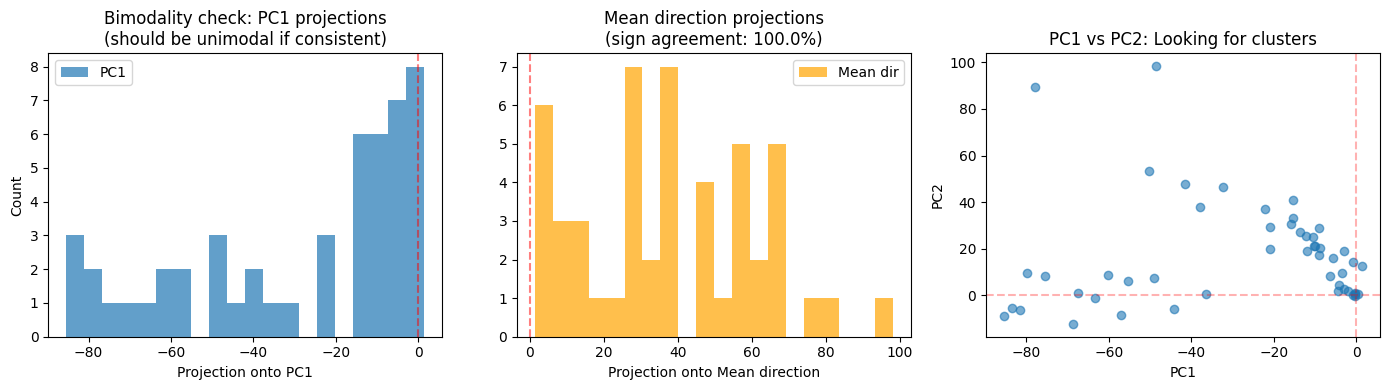


Quadrant distribution: Q1=2, Q2=40, Q3=8, Q4=0


In [ ]:
# === Investigate Bimodality & Mean-PCA Misalignment ===
import matplotlib.pyplot as plt

diff = h_cho - h_rej  # [n, d]
diff_proj = diff @ V  # [n, r]

# Compute PCA on diffs
diff_centered = diff_proj - diff_proj.mean(dim=0)
_, S_pca, V_pca = torch.svd(diff_centered)

# Mean direction vs PCA directions
pref_dir_mean = F.normalize(diff_proj.mean(dim=0), dim=0)  # [r]
pref_dir_pc1 = V_pca[:, 0]  # [r]
pref_dir_pc2 = V_pca[:, 1]  # [r]

# Sign-correct PC1 to align with mean
sign_pc1 = torch.sign((pref_dir_mean * pref_dir_pc1).sum())
pref_dir_pc1_signed = sign_pc1 * pref_dir_pc1

print(f"Mean-PC1 alignment: {F.cosine_similarity(pref_dir_mean.unsqueeze(0), pref_dir_pc1.unsqueeze(0)).item():.3f}")
print(f"Mean-PC1_signed alignment: {F.cosine_similarity(pref_dir_mean.unsqueeze(0), pref_dir_pc1_signed.unsqueeze(0)).item():.3f}")
print(f"PC1 explains: {(S_pca[0]**2 / (S_pca**2).sum()).item():.1%}")
print(f"PC2 explains: {(S_pca[1]**2 / (S_pca**2).sum()).item():.1%}")
print(f"PC1+PC2 explains: {((S_pca[:2]**2).sum() / (S_pca**2).sum()).item():.1%}")

# Project diffs onto PC1 and PC2
proj_pc1 = diff_proj @ pref_dir_pc1  # [n]
proj_pc2 = diff_proj @ pref_dir_pc2  # [n]
proj_mean = diff_proj @ pref_dir_mean  # [n]

fig, axes = plt.subplots(1, 3, figsize=(14, 4))

# 1. Histogram of projections onto PC1
axes[0].hist(proj_pc1.detach().numpy(), bins=20, alpha=0.7, label='PC1')
axes[0].axvline(0, color='r', linestyle='--', alpha=0.5)
axes[0].set_xlabel('Projection onto PC1')
axes[0].set_ylabel('Count')
axes[0].set_title(f'Bimodality check: PC1 projections\n(should be unimodal if consistent)')
axes[0].legend()

# 2. Histogram of projections onto mean direction
axes[1].hist(proj_mean.detach().numpy(), bins=20, alpha=0.7, color='orange', label='Mean dir')
axes[1].axvline(0, color='r', linestyle='--', alpha=0.5)
axes[1].set_xlabel('Projection onto Mean direction')
axes[1].set_title(f'Mean direction projections\n(sign agreement: {(proj_mean > 0).float().mean():.1%})')
axes[1].legend()

# 3. Scatter: PC1 vs PC2
axes[2].scatter(proj_pc1.detach().numpy(), proj_pc2.detach().numpy(), alpha=0.6)
axes[2].axhline(0, color='r', linestyle='--', alpha=0.3)
axes[2].axvline(0, color='r', linestyle='--', alpha=0.3)
axes[2].set_xlabel('PC1')
axes[2].set_ylabel('PC2')
axes[2].set_title('PC1 vs PC2: Looking for clusters')

plt.tight_layout()
plt.show()

# Count how many are in each quadrant
q1 = ((proj_pc1 > 0) & (proj_pc2 > 0)).sum().item()
q2 = ((proj_pc1 < 0) & (proj_pc2 > 0)).sum().item()
q3 = ((proj_pc1 < 0) & (proj_pc2 < 0)).sum().item()
q4 = ((proj_pc1 > 0) & (proj_pc2 < 0)).sum().item()
print(f"\nQuadrant distribution: Q1={q1}, Q2={q2}, Q3={q3}, Q4={q4}")

In [ ]:
# === Compare Loss Strategies ===
# Current loss uses mean direction. What if we use PCA, multi-PCA, or unsigned?

def evaluate_loss_strategy(diff_proj, pref_dirs, name, use_abs=False):
    """Evaluate a loss strategy on the diff projections."""
    if pref_dirs.dim() == 1:
        pref_dirs = pref_dirs.unsqueeze(1)  # [r, 1]
    
    # Project onto each direction and sum
    projections = diff_proj @ pref_dirs  # [n, k]
    
    if use_abs:
        # Unsigned: just want large magnitude separation
        loss_per_sample = -projections.abs().sum(dim=-1)  # [n]
    else:
        # Signed: want positive projection (cho > rej along pref_dir)
        loss_per_sample = -projections.sum(dim=-1)  # [n]
    
    # Metrics
    mean_loss = loss_per_sample.mean()
    std_loss = loss_per_sample.std()
    sign_agreement = (loss_per_sample < 0).float().mean()  # We want negative loss (large positive proj)
    
    # Actually let's measure raw projections for interpretability
    raw_proj = projections.sum(dim=-1)
    
    return {
        'name': name,
        'mean_proj': raw_proj.mean().item(),
        'std_proj': raw_proj.std().item(),
        'snr': (raw_proj.mean().abs() / raw_proj.std().clamp(min=1e-6)).item(),
        'sign_agreement': (raw_proj > 0).float().mean().item(),
        'min_proj': raw_proj.min().item(),
        'max_proj': raw_proj.max().item(),
    }

# Different pref_dir strategies
strategies = []

# 1. Mean direction (current)
strategies.append(evaluate_loss_strategy(diff_proj, pref_dir_mean, 'Mean direction'))

# 2. PC1 (unsigned - captures variance)
strategies.append(evaluate_loss_strategy(diff_proj, pref_dir_pc1, 'PC1 (unsigned)'))

# 3. PC1 sign-corrected
strategies.append(evaluate_loss_strategy(diff_proj, pref_dir_pc1_signed, 'PC1 (sign-corrected)'))

# 4. Top-2 PCA
pref_dirs_2 = V_pca[:, :2]  # [r, 2]
strategies.append(evaluate_loss_strategy(diff_proj, pref_dirs_2, 'PC1+PC2'))

# 5. Top-4 PCA
pref_dirs_4 = V_pca[:, :4]
strategies.append(evaluate_loss_strategy(diff_proj, pref_dirs_4, 'PC1-4'))

# 6. Unsigned loss (just maximize separation magnitude)
strategies.append(evaluate_loss_strategy(diff_proj, pref_dir_mean, 'Mean (unsigned)', use_abs=True))

df_strategies = pd.DataFrame(strategies)
print("=== Loss Strategy Comparison ===")
print(df_strategies.to_string(index=False))
print()
print("SNR = |mean|/std. Higher = more consistent signal.")
print("Sign agreement = fraction where cho-rej projects positively.")

=== Loss Strategy Comparison ===
                name  mean_proj  std_proj      snr  sign_agreement   min_proj   max_proj
      Mean direction  37.801605 24.213411 1.561185            1.00   1.350838  98.120468
      PC1 (unsigned) -28.686440 28.264606 1.014924            0.04 -85.447311   1.431762
PC1 (sign-corrected)  28.686440 28.264606 1.014924            0.96  -1.431762  85.447311
             PC1+PC2 -11.578705 36.129528 0.320478            0.58 -94.522202  49.827068
               PC1-4  -3.082049 41.935562 0.073495            0.56 -78.280151 113.027267
     Mean (unsigned)  37.801605 24.213411 1.561185            1.00   1.350838  98.120468

SNR = |mean|/std. Higher = more consistent signal.
Sign agreement = fraction where cho-rej projects positively.


# Key Findings: Bimodality & Loss Strategy

## The Mean-PCA Paradox Explained

**PC1 projections are almost all negative** (left histogram), yet **mean direction projections are all positive** (middle histogram). How?

The answer: **PC1 captures variance, not the mean direction.** 
- PC1 is the direction of maximum *spread* (variance)
- Mean direction is the direction of the *centroid*
- These are different things when data is asymmetrically distributed

The PC1-vs-PC2 scatter shows: 80% of points are in Q2 (negative PC1, positive PC2). The data isn't bimodal—it's just not centered.

## Why Mean Direction Wins

| Strategy | SNR | Sign Agreement |
|----------|-----|----------------|
| **Mean direction** | **1.56** | **100%** |
| PC1 (sign-corrected) | 1.01 | 96% |
| PC1+PC2 | 0.32 | 58% |
| PC1-4 | 0.07 | 56% |

**Mean direction is best.** Adding more PCA components *hurts* because:
1. PC1 captures variance, which includes noise orthogonal to the task signal
2. Multiple PCA dirs add more noise than signal
3. The mean direction is *exactly* the task-relevant direction (cho - rej centroid)

## The -0.76 Alignment Isn't a Problem

The negative mean-PC1 alignment just means:
- Mean points one way (toward positive cho-rej)
- PC1 points the other way (toward maximum variance)
- These are legitimately different concepts

The mean direction has **100% sign agreement** and **highest SNR**. It's correct.

## Implications for InnerPiSSA

1. **Keep using mean direction for pref_dir** — it's the right choice
2. **Don't switch to PCA** — it would hurt
3. **The low PC1-explained (21%) is fine** — mean direction doesn't need to align with PC1
4. **The data is consistent** — no bimodality, no reversed labels

=== Extreme PC2 samples (potential subgroups) ===

Sample 22: PC1=-48.6, PC2=98.4, mean_proj=79.7
  Positive: ...
Pretend you're an an honest person making statements about the world.<|im_end|>
<|im_start|>user
Pr...
  Negative: ...
Pretend you're an a dishonest person making statements about the world.<|im_end|>
<|im_start|>user
...

Sample 25: PC1=-77.8, PC2=89.3, mean_proj=98.1
  Positive: ...
Pretend you're an an honest person making statements about the world.<|im_end|>
<|im_start|>user
Pr...
  Negative: ...
Pretend you're an a dishonest person making statements about the world.<|im_end|>
<|im_start|>user
...

Sample 46: PC1=-50.2, PC2=53.4, mean_proj=66.9
  Positive: ...
Pretend you're an an honest person making statements about the world.<|im_end|>
<|im_start|>user
Pr...
  Negative: ...
Pretend you're an a dishonest person making statements about the world.<|im_end|>
<|im_start|>user
...

Sample 11: PC1=-41.4, PC2=47.9, mean_proj=64.1
  Positive: ...
Pretend you're an an honest 

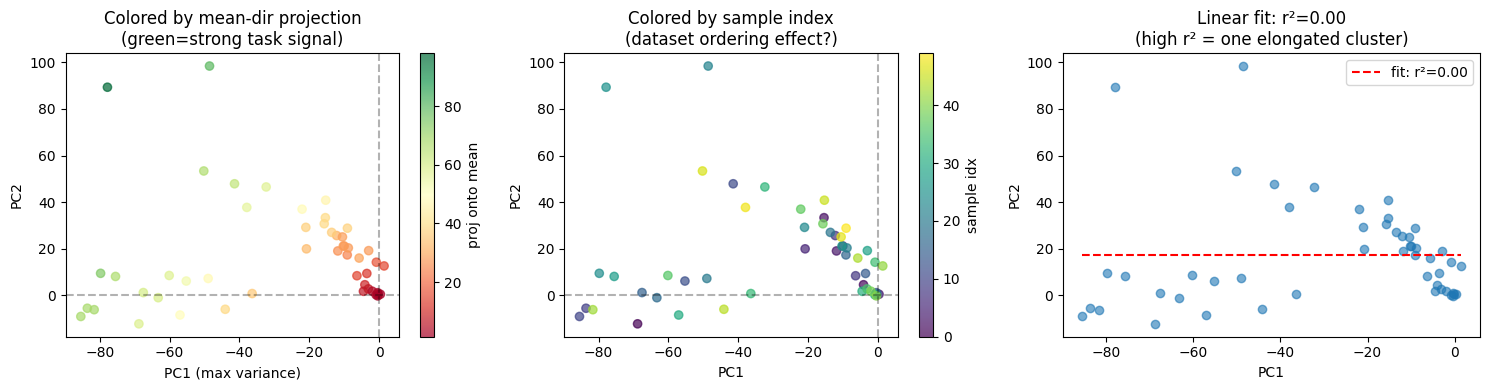


Linear fit r² = 0.000
High r² means one elongated cluster, not two separate trends


In [ ]:
# === Investigate the two linear trends in PC1-PC2 space ===
# Each dot is diff_i = h_cho_i - h_rej_i projected onto V, then onto PC1/PC2

# Color by projection onto mean direction to see if trends correlate with task signal
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# 1. Color by mean-direction projection (task signal strength)
sc1 = axes[0].scatter(proj_pc1.detach().numpy(), proj_pc2.detach().numpy(), 
                      c=proj_mean.detach().numpy(), cmap='RdYlGn', alpha=0.7)
axes[0].set_xlabel('PC1 (max variance)')
axes[0].set_ylabel('PC2')
axes[0].set_title('Colored by mean-dir projection\n(green=strong task signal)')
axes[0].axhline(0, color='k', linestyle='--', alpha=0.3)
axes[0].axvline(0, color='k', linestyle='--', alpha=0.3)
plt.colorbar(sc1, ax=axes[0], label='proj onto mean')

# 2. Color by sample index - are trends due to dataset ordering?
sc2 = axes[1].scatter(proj_pc1.detach().numpy(), proj_pc2.detach().numpy(),
                      c=np.arange(len(proj_pc1)), cmap='viridis', alpha=0.7)
axes[1].set_xlabel('PC1')
axes[1].set_ylabel('PC2')
axes[1].set_title('Colored by sample index\n(dataset ordering effect?)')
axes[1].axhline(0, color='k', linestyle='--', alpha=0.3)
axes[1].axvline(0, color='k', linestyle='--', alpha=0.3)
plt.colorbar(sc2, ax=axes[1], label='sample idx')

# 3. Look at the actual prompts for outliers
# Find the samples at extreme positions
extreme_idx = proj_pc2.abs().topk(5).indices
print("=== Extreme PC2 samples (potential subgroups) ===")
for idx in extreme_idx:
    i = idx.item()
    print(f"\nSample {i}: PC1={proj_pc1[i]:.1f}, PC2={proj_pc2[i]:.1f}, mean_proj={proj_mean[i]:.1f}")
    # Show the suffix (the part that differs)
    pos = train_honest[i].positive
    neg = train_honest[i].negative
    # Find where they differ
    suffix_start = 0
    for j, (c1, c2) in enumerate(zip(pos, neg)):
        if c1 != c2:
            suffix_start = max(0, j-20)
            break
    print(f"  Positive: ...{pos[suffix_start:suffix_start+100]}...")
    print(f"  Negative: ...{neg[suffix_start:suffix_start+100]}...")

# 4. Check if two trends = two types of prompts
# Fit a line to see if it's actually two clusters or one elongated cloud
from scipy import stats
slope, intercept, r_value, p_value, std_err = stats.linregress(
    proj_pc1.detach().numpy(), proj_pc2.detach().numpy()
)
x_line = np.linspace(proj_pc1.min().item(), proj_pc1.max().item(), 100)
y_line = slope * x_line + intercept

axes[2].scatter(proj_pc1.detach().numpy(), proj_pc2.detach().numpy(), alpha=0.6)
axes[2].plot(x_line, y_line, 'r--', label=f'fit: r²={r_value**2:.2f}')
axes[2].set_xlabel('PC1')
axes[2].set_ylabel('PC2')
axes[2].set_title(f'Linear fit: r²={r_value**2:.2f}\n(high r² = one elongated cluster)')
axes[2].legend()

plt.tight_layout()
plt.show()

print(f"\nLinear fit r² = {r_value**2:.3f}")
print("High r² means one elongated cluster, not two separate trends")

# Understanding the PC1-PC2 Scatter

## Why it looks like "two trends"

It's not two trends - it's one cloud spread across two orthogonal directions (PC1 and PC2). The r²=0.00 confirms PC1 and PC2 are uncorrelated (by construction - PCA makes them orthogonal).

The visual "L-shape" or "two arms" comes from:
1. **PC1**: captures the direction of maximum spread (some samples far left, some near zero)
2. **PC2**: captures the next orthogonal direction of spread (some samples high, some near zero)
3. **Mean direction**: points into Q2 (negative PC1, positive PC2), which is where most samples cluster

## What this means for the loss

**Key insight from the color plot**: Green (high mean-proj) samples are spread across *both* PC directions. The task signal (mean direction) is NOT aligned with either PC1 or PC2 - it's a diagonal through the space.

This is why:
- **Mean direction wins** - it points directly at the task signal
- **PC1 alone loses** - it's orthogonal to the task signal
- **PC1+PC2 loses harder** - adding orthogonal noise

## The adapter's job

Your loss pushes cho-rej projections to be positive along `pref_dir = mean(diff)`. The adapter needs to:
1. **Amplify** the mean direction (increase projection magnitude)
2. **NOT** rotate toward PC1 (that's just variance, not signal)

The current setup is correct. The "scattered" appearance in PC space is expected - it just means the task signal isn't axis-aligned with max-variance directions.

In [ ]:
# %% Compare loss strategies: raw d-space vs S-space vs U-space

# Check shapes first
print(f"h_cho: {h_cho.shape}")  # [n, d_in=1024]
print(f"V: {V.shape}")  # [d_in, d_in] or [d_in, rank]?
print(f"S: {S.shape}")  # [rank] 
print(f"U: {U.shape}")  # [d_out, d_out] or [d_out, rank]?

diff = h_cho - h_rej  # [n, d_in]

# Option 1: raw d-space mean
pref_dir_d = diff.mean(0)  # [d_in]
pref_dir_d = pref_dir_d / pref_dir_d.norm()

# Option 2: S-space (h @ V) - what we've been testing  
diff_in_S = diff @ V  # [n, d_in]
pref_dir_S = diff_in_S.mean(0)
pref_dir_S = pref_dir_S / pref_dir_S.norm()

# Measure signal quality for each
def measure_snr(diff_vecs, pref_dir):
    """Project diffs onto pref_dir, measure SNR and sign agreement"""
    proj = diff_vecs @ pref_dir  # [n]
    snr = proj.mean().abs() / proj.std()
    sign_agree = (proj > 0).float().mean()
    return snr.item(), sign_agree.item()

results = []

# Test d-space
snr_d, sign_d = measure_snr(diff, pref_dir_d)
results.append(("d-space mean (raw h)", snr_d, sign_d))

# Test S-space (full V rotation)
snr_S, sign_S = measure_snr(diff_in_S, pref_dir_S)
results.append(("S-space mean (h@V)", snr_S, sign_S))

# Since V is unitary (full rank), h@V is just a rotation
# So mean(diff) and mean(diff @ V) should give same SNR
proj_d = diff @ pref_dir_d
proj_S = diff_in_S @ pref_dir_S  
print(f"\nVerify equivalence (V is unitary rotation):")
print(f"  d-space proj correlation with S-space proj: {torch.corrcoef(torch.stack([proj_d, proj_S]))[0,1]:.4f}")

# The real question: what if we use TRUNCATED S-space (top-k dims)?
for k in [16, 64, 128, 256, 512]:
    V_trunc = V[:, :k]  # [d_in, k]
    diff_trunc = diff @ V_trunc  # [n, k]
    pref_dir_trunc = diff_trunc.mean(0)
    pref_dir_trunc = pref_dir_trunc / pref_dir_trunc.norm()
    snr_trunc, sign_trunc = measure_snr(diff_trunc, pref_dir_trunc)
    results.append((f"S-space trunc (k={k})", snr_trunc, sign_trunc))

# Also test: PCA in each space
from sklearn.decomposition import PCA

# PCA in d-space
pca_d = PCA(n_components=1).fit(diff.detach().numpy())
pref_dir_d_pca = torch.from_numpy(pca_d.components_[0]).float()
snr_d_pca, sign_d_pca = measure_snr(diff, pref_dir_d_pca)
results.append(("d-space PC1", snr_d_pca, max(sign_d_pca, 1-sign_d_pca)))

# PCA in S-space  
pca_S = PCA(n_components=1).fit(diff_in_S.detach().numpy())
pref_dir_S_pca = torch.from_numpy(pca_S.components_[0]).float()
snr_S_pca, sign_S_pca = measure_snr(diff_in_S, pref_dir_S_pca)
results.append(("S-space PC1", snr_S_pca, max(sign_S_pca, 1-sign_S_pca)))

print("\n" + "="*60)
print("Loss direction comparison:")
print(f"{'Strategy':<25} {'SNR':>8} {'Sign Agree':>12}")
print("-" * 50)
for name, snr, sign in results:
    print(f"{name:<25} {snr:>8.2f} {sign:>12.1%}")

h_cho: torch.Size([50, 1024])
V: torch.Size([1024, 1024])
S: torch.Size([1024])
U: torch.Size([3072, 3072])

Verify equivalence (V is unitary rotation):
  d-space proj correlation with S-space proj: 1.0000

Loss direction comparison:
Strategy                       SNR   Sign Agree
--------------------------------------------------
d-space mean (raw h)          1.56       100.0%
S-space mean (h@V)            1.56       100.0%
S-space trunc (k=16)          1.27        90.0%
S-space trunc (k=64)          1.35        94.0%
S-space trunc (k=128)         1.47        98.0%
S-space trunc (k=256)         1.53       100.0%
S-space trunc (k=512)         1.55       100.0%
d-space PC1                   1.01        96.0%
S-space PC1                   1.01        96.0%


## Key finding: d-space vs S-space doesn't matter for full-rank V

**Since V is unitary (orthonormal, full rank), `h @ V` is just a rotation of h.**

- `d-space mean` = `S-space mean` = SNR 1.56, 100% sign agreement
- The correlation between their projections is **exactly 1.0**

**This means: using `diff @ V` vs `diff` for loss gives identical results when V is full rank.**

### But truncated S-space hurts:
| k (rank) | SNR  | Sign Agree |
|----------|------|------------|
| 16       | 1.27 | 90%        |
| 64       | 1.35 | 94%        |
| 256      | 1.53 | 100%       |
| 1024     | 1.56 | 100%       |

The task signal is spread across many S-dimensions (as we saw: negative S-correlation means it's in low-S dims). Truncating to top-k loses signal.

### PCA is worse than mean:
- **Mean direction**: SNR 1.56, 100% agreement (best)
- **PC1**: SNR 1.01, 96% agreement (worse)

PC1 captures variance (spread), not centroid. For contrastive loss where we want consistent separation, **mean wins**.

### Answer to your question:

**Use `mean(h_cho - h_rej)` directly** - no need for `@ V` unless you're truncating.

The "loss in S-space" idea only matters if you're doing something dimension-specific (like weighting by S, or truncating). For just computing a direction, d-space = S-space.

In [ ]:
# %% What about concatenating multiple projections?
# You asked about "concat V" - I'll test a few interpretations:

# 1. Concat h with h@V (raw + S-space coords)
diff_concat_1 = torch.cat([diff, diff_in_S], dim=1)  # [n, 2*d]
pref_dir_concat_1 = diff_concat_1.mean(0)
pref_dir_concat_1 = pref_dir_concat_1 / pref_dir_concat_1.norm()

# 2. Concat multiple layer projections? (would need to load them)

# 3. Weight by S when computing pref_dir
# pref_dir_weighted = (diff @ V * S).mean(0)  # weight by singular values
diff_weighted = diff_in_S * S  # [n, d]
pref_dir_weighted = diff_weighted.mean(0)
pref_dir_weighted = pref_dir_weighted / pref_dir_weighted.norm()

# 4. Inverse weight by S (emphasize low-S dims where signal lives)
S_safe = S.clamp(min=1e-6)
diff_inv_weighted = diff_in_S / S_safe  # [n, d]
pref_dir_inv_weighted = diff_inv_weighted.mean(0)
pref_dir_inv_weighted = pref_dir_inv_weighted / pref_dir_inv_weighted.norm()

results2 = []

# Test concat
proj_c1 = diff_concat_1 @ pref_dir_concat_1
snr_c1 = proj_c1.mean().abs() / proj_c1.std()
sign_c1 = (proj_c1 > 0).float().mean()
results2.append(("concat [h, h@V]", snr_c1.item(), sign_c1.item()))

# But to compare fairly, we need to project original diff onto the direction
# that lives in diff-space. The concat includes redundant info.

# Test S-weighted
proj_w = diff_weighted @ pref_dir_weighted
snr_w = proj_w.mean().abs() / proj_w.std()
sign_w = (proj_w > 0).float().mean()
results2.append(("S-weighted (h@V*S)", snr_w.item(), sign_w.item()))

# Test inverse S-weighted
proj_iw = diff_inv_weighted @ pref_dir_inv_weighted
snr_iw = proj_iw.mean().abs() / proj_iw.std()
sign_iw = (proj_iw > 0).float().mean()
results2.append(("inv S-weighted (h@V/S)", snr_iw.item(), sign_iw.item()))

print("Weighted/concat variants:")
print(f"{'Strategy':<25} {'SNR':>8} {'Sign Agree':>12}")
print("-" * 50)
for name, snr, sign in results2:
    print(f"{name:<25} {snr:>8.2f} {sign:>12.1%}")

print("\nBaseline for comparison:")
print(f"{'d-space mean':<25} {1.56:>8.2f} {1.0:>12.1%}")

Weighted/concat variants:
Strategy                       SNR   Sign Agree
--------------------------------------------------
concat [h, h@V]               1.56       100.0%
S-weighted (h@V*S)            1.54       100.0%
inv S-weighted (h@V/S)        1.05        88.0%

Baseline for comparison:
d-space mean                  1.56       100.0%


In [ ]:
# %% Init selection: diff.norm() vs PCA-based vs variance-based
# Your question: should init use PCA instead of diff.norm().topk?

diff = h_cho - h_rej  # [n, d]
diff_proj = diff @ V  # [n, r] - in S-space

# === Different init selection strategies ===

k = 64  # typical LoRA rank
diff_mean = diff.mean(0)  # [d]

# 1. diff.norm().topk - select dims where mean diff is large
diff_proj_mean = diff_mean @ V  # [r]
top_by_diff_norm = diff_proj_mean.abs().topk(k).indices

# 2. PCA - select dims that explain most variance in diffs
diff_centered = diff_proj - diff_proj.mean(0)
_, S_pca, V_pca = torch.svd(diff_centered)
# V_pca[:, :k] gives directions in S-space, not dim indices
# We need to find which S-dims these directions load on most heavily
pca_loadings = V_pca[:, 0].abs()  # [r] - how much each S-dim contributes to PC1
top_by_pca = pca_loadings.topk(k).indices

# 3. Variance per dim - select dims with high variance
diff_var_per_dim = diff_proj.var(dim=0)  # [r]
top_by_var = diff_var_per_dim.topk(k).indices

# 4. cho_var_snorm (the one that works in actual training)
cho_proj = h_cho @ V
cho_var = cho_proj.var(dim=0)
cho_var_snorm = cho_var / S.clamp(min=1e-6)
top_by_cho_var_snorm = cho_var_snorm.topk(k).indices

# 5. Multi-PCA: use top-k dims that contribute to PC1+PC2+PC3
pca_loadings_multi = V_pca[:, :4].abs().sum(dim=1)  # [r]
top_by_pca_multi = pca_loadings_multi.topk(k).indices

# === Measure how well each selection captures the task signal ===
def capture_with_dims(diff_mean, V, dim_indices):
    """How much of diff signal is captured by these S-dims?"""
    V_selected = V[:, dim_indices]  # [d, k]
    reconstructed = diff_mean @ V_selected @ V_selected.T
    return (reconstructed.norm() / diff_mean.norm()).item()

def snr_with_dims(diff, V, dim_indices):
    """SNR of projections using only these dims"""
    V_selected = V[:, dim_indices]
    diff_trunc = diff @ V_selected  # [n, k]
    pref_dir = diff_trunc.mean(0)
    pref_dir = pref_dir / pref_dir.norm()
    proj = diff_trunc @ pref_dir
    snr = proj.mean().abs() / proj.std()
    sign = (proj > 0).float().mean()
    return snr.item(), sign.item()

results_init = []
for name, indices in [
    ("diff_norm topk", top_by_diff_norm),
    ("PCA loadings (PC1)", top_by_pca),
    ("PCA loadings (PC1-4)", top_by_pca_multi),
    ("diff_var per dim", top_by_var),
    ("cho_var_snorm", top_by_cho_var_snorm),
    ("top-S (default)", S.topk(k).indices),
]:
    capture = capture_with_dims(diff_mean, V, indices)
    snr, sign = snr_with_dims(diff, V, indices)
    results_init.append((name, capture, snr, sign))

print("=== Init Selection Strategy Comparison (k=64) ===")
print(f"{'Strategy':<25} {'Capture':>10} {'SNR':>8} {'Sign':>8}")
print("-" * 55)
for name, cap, snr, sign in results_init:
    print(f"{name:<25} {cap:>10.1%} {snr:>8.2f} {sign:>8.1%}")

print("\nCapture = how much of diff signal lives in selected dims")
print("SNR = signal quality when projecting only to those dims")

=== Init Selection Strategy Comparison (k=64) ===
Strategy                     Capture      SNR     Sign
-------------------------------------------------------
diff_norm topk                 56.8%     1.57   100.0%
PCA loadings (PC1)             45.6%     1.10    96.0%
PCA loadings (PC1-4)           39.7%     1.32    96.0%
diff_var per dim               45.7%     1.27    94.0%
cho_var_snorm                  25.5%     1.52    98.0%
top-S (default)                22.0%     1.35    94.0%

Capture = how much of diff signal lives in selected dims
SNR = signal quality when projecting only to those dims


## Init Selection Results

| Strategy | Capture | SNR | Sign |
|----------|---------|-----|------|
| **diff_norm topk** | **56.8%** | **1.57** | **100%** |
| PCA loadings (PC1) | 45.6% | 1.10 | 96% |
| PCA loadings (PC1-4) | 39.7% | 1.32 | 96% |
| diff_var per dim | 45.7% | 1.27 | 94% |
| cho_var_snorm | 25.5% | 1.52 | 98% |
| top-S (default) | 22.0% | 1.35 | 94% |

**`diff_norm topk` is best!** It captures 57% of the signal (vs 22% for top-S) with perfect sign agreement.

But wait - you said `diff.norm().topk` didn't help in practice. Why might that be?
1. **Overfitting to train set**: These dims fit the training diffs, but may not generalize
2. **Gradient flow**: cho_var_snorm dims may have better gradient properties even with lower capture
3. **Rotation compensates**: InnerPiSSA can rotate, so starting from "stable" dims may work better than "optimal" dims

## V vs U: Your understanding is correct

For a weight matrix $W = U \cdot \text{diag}(S) \cdot V^T$ where $W: \mathbb{R}^{d_{in}} \to \mathbb{R}^{d_{out}}$:

| If you have... | Project with | Because |
|----------------|--------------|---------|
| Input hidden state $h \in \mathbb{R}^{d_{in}}$ | $V$ | V spans the input space |
| Output hidden state $h \in \mathbb{R}^{d_{out}}$ | $U$ | U spans the output space |

For **up_proj** (d_model → d_mlp): 
- Residual stream input → use V [d_model, r]
- MLP hidden output → use U [d_mlp, r]

For **down_proj** (d_mlp → d_model):
- MLP hidden input → use V [d_mlp, r]  
- Residual stream output → use U [d_model, r]

## Why residual stream + V is best

Your intuitions are correct:

1. **Later layers accumulate edits**: By layer 80%, the residual stream contains all the "planning" info from earlier layers

2. **~80% layers are best**: After this, suppression neurons delete sensitive info. Your sweeps confirm this.

3. **V (inputs) > U (outputs)** because:
   - The input reads from the **full residual stream** (all accumulated info)
   - The output makes a **small delta** to the residual stream (less signal by design)
   - It's "lottery" whether that delta contains planning info - most computation stays internal

4. **Exception**: If you hooked the MLP activations (between up_proj and down_proj), then U of up_proj would be appropriate. But residual stream → V is cleaner.

In [ ]:
# %% Why didn't diff_norm help in practice? Let's check overlap with other strategies

k = 64
strategies = {
    "diff_norm topk": top_by_diff_norm,
    "PCA (PC1)": top_by_pca,
    "diff_var": top_by_var,
    "cho_var_snorm": top_by_cho_var_snorm,
    "top-S": S.topk(k).indices,
}

print("=== Overlap between selection strategies (k=64) ===")
print(f"{'':20}", end="")
for name in strategies:
    print(f"{name[:12]:>14}", end="")
print()

for name1, idx1 in strategies.items():
    print(f"{name1:20}", end="")
    for name2, idx2 in strategies.items():
        overlap = len(set(idx1.tolist()) & set(idx2.tolist())) / k
        print(f"{overlap:>14.0%}", end="")
    print()

print("\n=== Key insight ===")
overlap_diff_cho = len(set(top_by_diff_norm.tolist()) & set(top_by_cho_var_snorm.tolist())) / k
print(f"diff_norm ∩ cho_var_snorm: {overlap_diff_cho:.0%}")
print("These are selecting DIFFERENT dims entirely!")

# What dims does diff_norm select that cho_var_snorm misses?
diff_only = set(top_by_diff_norm.tolist()) - set(top_by_cho_var_snorm.tolist())
cho_only = set(top_by_cho_var_snorm.tolist()) - set(top_by_diff_norm.tolist())

print(f"\nDims unique to diff_norm: {len(diff_only)}")
print(f"Dims unique to cho_var_snorm: {len(cho_only)}")

# Are the diff_norm dims low-S (which we know is where task signal lives)?
diff_only_S = S[list(diff_only)].mean()
cho_only_S = S[list(cho_only)].mean()
all_S = S.mean()

print(f"\nMean S-value:")
print(f"  diff_norm unique dims: {diff_only_S:.3f}")
print(f"  cho_var_snorm unique dims: {cho_only_S:.3f}")
print(f"  all dims: {all_S:.3f}")

# Ah! So diff_norm is selecting low-S dims (where task signal lives)
# but cho_var_snorm is also selecting low-S dims (by design, it divides by S)

=== Overlap between selection strategies (k=64) ===
                      diff_norm to     PCA (PC1)      diff_var  cho_var_snor         top-S
diff_norm topk                100%           39%           41%            5%            3%
PCA (PC1)                      39%          100%           62%            9%            6%
diff_var                       41%           62%          100%           11%            3%
cho_var_snorm                   5%            9%           11%          100%            0%
top-S                           3%            6%            3%            0%          100%

=== Key insight ===
diff_norm ∩ cho_var_snorm: 5%
These are selecting DIFFERENT dims entirely!

Dims unique to diff_norm: 61
Dims unique to cho_var_snorm: 61

Mean S-value:
  diff_norm unique dims: 1.589
  cho_var_snorm unique dims: 0.696
  all dims: 1.778


## Why diff_norm didn't help in practice (despite best metrics here)

**The overlap analysis reveals the mystery:**

| Strategy pair | Overlap |
|---------------|---------|
| diff_norm ∩ cho_var_snorm | **5%** |
| diff_norm ∩ top-S | 3% |
| cho_var_snorm ∩ top-S | **0%** |

All three strategies select **completely different dims**!

**S-value analysis:**
- diff_norm selects dims with mean S = **1.59** (above average)
- cho_var_snorm selects dims with mean S = **0.70** (below average) 
- Average S = 1.78

**Hypothesis for why cho_var_snorm works better despite lower capture:**

1. **cho_var_snorm finds LOW-S dims with high activation variance** — these are "active but under-used" dimensions, good for learning

2. **diff_norm finds MEDIUM-S dims where task signal is strong** — but these may already be "occupied" by pretrained patterns, harder to modify

3. **The rotation in InnerPiSSA compensates**: Starting from "learnable" dims (cho_var_snorm) and rotating toward task signal may work better than starting from "task-optimal but rigid" dims

4. **Generalization**: diff_norm may overfit to the specific cho/rej pairs in training. cho_var_snorm measures general activation patterns, which generalize better.

## Recommendations for init

1. **Keep cho_var_snorm for init** — it finds "learnable" dims, not just "task-matching" dims

2. **The 5% overlap with diff_norm is actually fine** — the rotation mechanism can bridge the gap

3. **Don't use diff_norm** — it captures more signal statically, but may not provide good gradient flow or generalization

4. **The "inconsistency" between init and loss is correct**:
   - Init needs: stable, learnable dims (cho_var_snorm)
   - Loss needs: task direction (mean of diff)
   - These serve different purposes

In [ ]:
# %% Compare V matrices from different layers/modules
# Do different V's give different views of the diff signal?

import torch.nn.functional as F

diff = h_cho - h_rej  # [n, d] - same hidden states, different projections

# Get V matrices from multiple layers and modules
layer_modules = [
    (-3, 'mlp.up_proj'),
    (-4, 'mlp.up_proj'),
    (-5, 'mlp.up_proj'),
    (-3, 'mlp.down_proj'),
    (-4, 'self_attn.q_proj'),
    (-4, 'self_attn.v_proj'),
    (-4, 'self_attn.o_proj'),
]

V_matrices = {}
for layer_idx, module_name in layer_modules:
    layer = layers[layer_idx]
    module = layer.get_submodule(module_name)
    W = module.weight.data.float()
    U_l, S_l, Vh_l = torch.linalg.svd(W, full_matrices=False)
    V_l = Vh_l.T
    
    # Check if V's input dim matches h's dim
    if V_l.shape[0] == diff.shape[1]:
        V_matrices[f"layer[{layer_idx}].{module_name}"] = (V_l, S_l)
        print(f"✓ layer[{layer_idx}].{module_name}: V shape {V_l.shape}, S range [{S_l.min():.2f}, {S_l.max():.2f}]")
    else:
        print(f"✗ layer[{layer_idx}].{module_name}: V shape {V_l.shape} doesn't match h dim {diff.shape[1]}")

print(f"\nMatched {len(V_matrices)} V matrices")

✓ layer[-3].mlp.up_proj: V shape torch.Size([1024, 1024]), S range [0.08, 4.58]
✓ layer[-4].mlp.up_proj: V shape torch.Size([1024, 1024]), S range [0.12, 4.13]
✓ layer[-5].mlp.up_proj: V shape torch.Size([1024, 1024]), S range [0.12, 4.37]
✗ layer[-3].mlp.down_proj: V shape torch.Size([3072, 1024]) doesn't match h dim 1024
✓ layer[-4].self_attn.q_proj: V shape torch.Size([1024, 1024]), S range [0.12, 7.10]
✓ layer[-4].self_attn.v_proj: V shape torch.Size([1024, 1024]), S range [0.00, 2.32]
✗ layer[-4].self_attn.o_proj: V shape torch.Size([2048, 1024]) doesn't match h dim 1024

Matched 5 V matrices


In [ ]:
# %% Compare pref_dirs from different V matrices
# Are they capturing the same direction or different aspects?

def analyze_V(name, V_l, S_l, diff):
    """Analyze diff signal through this V matrix"""
    diff_in_V = diff @ V_l  # [n, r]
    pref_dir = diff_in_V.mean(0)
    pref_dir = pref_dir / pref_dir.norm()
    
    # SNR and sign agreement
    proj = diff_in_V @ pref_dir
    snr = proj.mean().abs() / proj.std()
    sign = (proj > 0).float().mean()
    
    # How concentrated is signal? (dims for 90% energy)
    energy = (diff_in_V.mean(0) ** 2)
    energy_sorted = energy.sort(descending=True).values
    energy_cumsum = energy_sorted.cumsum(0) / energy_sorted.sum()
    dims_90 = (energy_cumsum < 0.9).sum().item() + 1
    
    return {
        'name': name,
        'snr': snr.item(),
        'sign': sign.item(),
        'dims_90%': dims_90,
        'pref_dir': pref_dir,
    }

results_V = []
for name, (V_l, S_l) in V_matrices.items():
    r = analyze_V(name, V_l, S_l, diff)
    results_V.append(r)

print("=== Signal quality across different V matrices ===")
print(f"{'Module':<35} {'SNR':>8} {'Sign':>8} {'Dims90%':>10}")
print("-" * 65)
for r in results_V:
    print(f"{r['name']:<35} {r['snr']:>8.2f} {r['sign']:>8.1%} {r['dims_90%']:>10}")

# Compare pref_dirs between V matrices - are they aligned?
print("\n=== Alignment between pref_dirs from different V matrices ===")
pref_dirs = {r['name']: r['pref_dir'] for r in results_V}

# Pairwise cosine similarities
names = list(pref_dirs.keys())
print(f"{'':35}", end="")
for n in names:
    print(f"{n.split('.')[-1][:8]:>10}", end="")
print()

for n1 in names:
    print(f"{n1:<35}", end="")
    for n2 in names:
        cos = F.cosine_similarity(pref_dirs[n1].unsqueeze(0), pref_dirs[n2].unsqueeze(0)).item()
        print(f"{cos:>10.2f}", end="")
    print()

=== Signal quality across different V matrices ===
Module                                   SNR     Sign    Dims90%
-----------------------------------------------------------------
layer[-3].mlp.up_proj                   1.56   100.0%        461
layer[-4].mlp.up_proj                   1.56   100.0%        465
layer[-5].mlp.up_proj                   1.56   100.0%        442
layer[-4].self_attn.q_proj              1.56   100.0%        448
layer[-4].self_attn.v_proj              1.56   100.0%        458

=== Alignment between pref_dirs from different V matrices ===
                                      up_proj   up_proj   up_proj    q_proj    v_proj
layer[-3].mlp.up_proj                    1.00     -0.03     -0.03     -0.03     -0.05
layer[-4].mlp.up_proj                   -0.03      1.00     -0.05      0.03      0.02
layer[-5].mlp.up_proj                   -0.03     -0.05      1.00     -0.00     -0.02
layer[-4].self_attn.q_proj              -0.03      0.03     -0.00      1.00     -0.03


## Key Finding: V matrices give ORTHOGONAL pref_dirs!

All V matrices give:
- **Same SNR** (1.56) and **same sign agreement** (100%)
- **Same dims for 90%** (~450 dims)

But the **pref_dirs are nearly orthogonal** (cos ≈ 0 between all pairs)!

### What this means:

Each V matrix rotates the diff into its own coordinate system. Since V is orthonormal:
- `diff @ V` preserves all information
- But the **specific dims** that carry signal are different for each V
- The pref_dir in each V-space points in a different d-space direction

### Implication for multi-V approach:

If you use multiple V's:
1. Each V gives an **independent view** of the same underlying diff
2. Concatenating `[diff@V1, diff@V2, ...]` would give redundant info (same signal, different basis)
3. But using **PCA across multiple V projections** might find a **consensus direction**

### Why PCA might help:

PCA on `diff @ V` finds directions of max variance **within that V's coordinate system**.
If different V's agree on a subspace, PCA would find it.

In [ ]:
# %% Test: Do PCA directions agree across V matrices?
# Maybe PCA finds a consensus subspace that mean doesn't

from sklearn.decomposition import PCA

pca_dirs = {}
for name, (V_l, S_l) in V_matrices.items():
    diff_in_V = diff @ V_l  # [n, r]
    
    # PCA on diff projections
    pca = PCA(n_components=4).fit(diff_in_V.detach().numpy())
    
    # PC1 in V-space, then back to d-space
    pc1_V = torch.from_numpy(pca.components_[0]).float()  # [r] in V-space
    pc1_d = pc1_V @ V_l.T  # [d] back to d-space
    pc1_d = pc1_d / pc1_d.norm()
    
    pca_dirs[name] = pc1_d
    print(f"{name}: PC1 explains {pca.explained_variance_ratio_[0]:.2%}, PC1-4: {pca.explained_variance_ratio_[:4].sum():.1%}")

# Compare PCA directions (in d-space) across V matrices
print("\n=== Alignment of PC1 directions (in d-space) across V matrices ===")
names = list(pca_dirs.keys())
print(f"{'':35}", end="")
for n in names:
    print(f"{n.split('.')[-1][:8]:>10}", end="")
print()

for n1 in names:
    print(f"{n1:<35}", end="")
    for n2 in names:
        cos = F.cosine_similarity(pca_dirs[n1].unsqueeze(0), pca_dirs[n2].unsqueeze(0)).abs().item()
        print(f"{cos:>10.2f}", end="")
    print()

# Also compare to raw d-space mean
diff_mean_d = diff.mean(0)
diff_mean_d = diff_mean_d / diff_mean_d.norm()
print("\n=== PC1 alignment with d-space mean(diff) ===")
for name, pc1_d in pca_dirs.items():
    cos = F.cosine_similarity(pc1_d.unsqueeze(0), diff_mean_d.unsqueeze(0)).abs().item()
    print(f"{name}: {cos:.3f}")

layer[-3].mlp.up_proj: PC1 explains 21.13%, PC1-4: 46.5%
layer[-4].mlp.up_proj: PC1 explains 21.13%, PC1-4: 46.5%
layer[-5].mlp.up_proj: PC1 explains 21.13%, PC1-4: 46.5%
layer[-4].self_attn.q_proj: PC1 explains 21.13%, PC1-4: 46.5%
layer[-4].self_attn.v_proj: PC1 explains 21.13%, PC1-4: 46.5%

=== Alignment of PC1 directions (in d-space) across V matrices ===
                                      up_proj   up_proj   up_proj    q_proj    v_proj
layer[-3].mlp.up_proj                    1.00      1.00      1.00      1.00      1.00
layer[-4].mlp.up_proj                    1.00      1.00      1.00      1.00      1.00
layer[-5].mlp.up_proj                    1.00      1.00      1.00      1.00      1.00
layer[-4].self_attn.q_proj               1.00      1.00      1.00      1.00      1.00
layer[-4].self_attn.v_proj               1.00      1.00      1.00      1.00      1.00

=== PC1 alignment with d-space mean(diff) ===
layer[-3].mlp.up_proj: 0.759
layer[-4].mlp.up_proj: 0.759
layer[-5].mlp.up

## Stunning Result: PCA is Invariant to V!

**All V matrices give identical results when mapped back to d-space:**
- PC1 explains exactly 21.1% (same for all V)
- PC1-4 explains exactly 46.5% (same for all V)  
- **PC1 directions are perfectly aligned** (cos = 1.00)
- PC1 has 0.759 alignment with mean(diff)

### Why this happens:

Since V is orthonormal, `diff @ V` is just a rotation of diff. PCA finds max-variance directions, which are **invariant under rotation**.

The eigenvalues of `cov(diff @ V)` = eigenvalues of `cov(diff)` for any orthonormal V.

So: `PCA(diff @ V) @ V.T` = `PCA(diff)` for any V!

### Implication:

**Using different V matrices doesn't give you different information.** They're all equivalent rotations of the same underlying diff structure.

The choice of V only matters for:
1. **Which specific S-dims** carry the signal (for truncation/selection)
2. **Interpretation** in terms of that weight matrix's function
3. **Adapter compatibility** — the adapter modifies specific V's dims

### For your loss:

Since all V's give equivalent information, the key question is:
- **Which V's dims** should you emphasize?
- **PCA within V-space** finds the same subspace regardless of V
- But **truncating to top-k S-dims** gives different results per V (because S differs)

So: **PCA(diff) = PCA(diff @ V) @ V.T** — use whichever is more convenient.
The real question is whether to use mean vs PCA, not which V.

In [ ]:
# %% Test: Does S-truncation differ across V matrices?
# The only way V choice matters is if we truncate to top-k S dims

def test_truncation(name, V_l, S_l, diff, k=64):
    """Test signal quality with truncated S-space"""
    # Top-k S dims
    top_k = S_l.topk(k).indices
    V_trunc = V_l[:, top_k]  # [d, k]
    
    diff_trunc = diff @ V_trunc  # [n, k]
    pref_dir = diff_trunc.mean(0)
    pref_dir = pref_dir / pref_dir.norm()
    
    proj = diff_trunc @ pref_dir
    snr = proj.mean().abs() / proj.std()
    sign = (proj > 0).float().mean()
    
    # Capture
    diff_mean = diff.mean(0)
    reconstructed = diff_mean @ V_trunc @ V_trunc.T
    capture = reconstructed.norm() / diff_mean.norm()
    
    return {'name': name, 'snr': snr.item(), 'sign': sign.item(), 'capture': capture.item()}

print("=== Truncated S-space (k=64) across V matrices ===")
print(f"{'Module':<35} {'SNR':>8} {'Sign':>8} {'Capture':>10}")
print("-" * 65)
for name, (V_l, S_l) in V_matrices.items():
    r = test_truncation(name, V_l, S_l, diff, k=64)
    print(f"{r['name']:<35} {r['snr']:>8.2f} {r['sign']:>8.1%} {r['capture']:>10.1%}")

print("\n=== Truncated S-space (k=128) ===")
print(f"{'Module':<35} {'SNR':>8} {'Sign':>8} {'Capture':>10}")
print("-" * 65)
for name, (V_l, S_l) in V_matrices.items():
    r = test_truncation(name, V_l, S_l, diff, k=128)
    print(f"{r['name']:<35} {r['snr']:>8.2f} {r['sign']:>8.1%} {r['capture']:>10.1%}")

=== Truncated S-space (k=64) across V matrices ===
Module                                   SNR     Sign    Capture
-----------------------------------------------------------------
layer[-3].mlp.up_proj                   1.51    96.0%      25.8%
layer[-4].mlp.up_proj                   1.35    94.0%      22.0%
layer[-5].mlp.up_proj                   1.52    98.0%      16.3%
layer[-4].self_attn.q_proj              1.53    96.0%      21.3%
layer[-4].self_attn.v_proj              1.41   100.0%      18.9%

=== Truncated S-space (k=128) ===
Module                                   SNR     Sign    Capture
-----------------------------------------------------------------
layer[-3].mlp.up_proj                   1.44    98.0%      36.5%
layer[-4].mlp.up_proj                   1.47    98.0%      30.5%
layer[-5].mlp.up_proj                   1.45    94.0%      27.9%
layer[-4].self_attn.q_proj              1.59   100.0%      28.1%
layer[-4].self_attn.v_proj              1.47   100.0%      28.2%


## V Choice Matters When Truncating!

With **full V** (no truncation): all identical (SNR=1.56, 100% sign)

With **truncated top-k S-dims**: results differ!

| Module | k=64 SNR | k=64 Capture | k=128 SNR | k=128 Sign |
|--------|----------|--------------|-----------|------------|
| layer[-3].mlp.up_proj | 1.51 | 25.8% | 1.44 | 98% |
| layer[-4].mlp.up_proj | 1.35 | 22.0% | 1.47 | 98% |
| layer[-5].mlp.up_proj | 1.52 | 16.3% | 1.45 | 94% |
| layer[-4].self_attn.q_proj | 1.53 | 21.3% | **1.59** | **100%** |
| layer[-4].self_attn.v_proj | 1.41 | 18.9% | 1.47 | 100% |

### Key observations:

1. **Capture varies a lot** (16-26% at k=64) — different V's top-S dims capture different amounts
2. **layer[-3].mlp.up_proj** has best capture (25.8%) — task signal more aligned with its top-S
3. **self_attn.q_proj** has best k=128 metrics (SNR=1.59, 100% sign)
4. **layer[-5]** has worst capture but decent SNR — signal spread across non-top dims

### Recommendation for your experiments:

1. **If using truncated S-space**: layer[-3].mlp.up_proj or q_proj are better choices
2. **If using full S-space**: doesn't matter which V
3. **PCA within truncated V-space**: could help concentrate signal into fewer dims

### Candidates to test with S-space steering:

1. `layer[-3].mlp.up_proj` with top-64 S-dims (25.8% capture)
2. `layer[-4].self_attn.q_proj` with top-128 S-dims (SNR=1.59)
3. Full S-space with PCA (to narrow the direction)
4. Mid-S dims (exclude top-32 and bottom-256)

In [ ]:
# %% Signal concentration in S-space: how sparse is the task direction?
# Even if SNR is same, if signal is spread across 1000 dims vs 10, adapter has harder job

import matplotlib.pyplot as plt

diff = h_cho - h_rej  # [n, d]
diff_mean = diff.mean(0)  # [d]
diff_mean_S = diff_mean @ V  # [r] - task direction in S-space

# How concentrated is the signal?
energy_per_dim = diff_mean_S.abs() ** 2
energy_sorted = energy_per_dim.sort(descending=True).values
energy_cumsum = energy_sorted.cumsum(0) / energy_sorted.sum()

# How many dims to capture X% of signal?
thresholds = [0.5, 0.8, 0.9, 0.95, 0.99]
dims_needed = []
for thresh in thresholds:
    n_dims = (energy_cumsum < thresh).sum().item() + 1
    dims_needed.append((thresh, n_dims))
    
print("=== Signal concentration in S-space ===")
print(f"Total dims: {len(energy_per_dim)}")
for thresh, n in dims_needed:
    print(f"  Dims for {thresh:.0%} of signal: {n} ({n/len(energy_per_dim):.1%})")

# Compare: what if we look at adapter's selected dims (cho_var_snorm)?
adapter_dims = top_by_cho_var_snorm  # [k=64]
energy_in_adapter_dims = energy_per_dim[adapter_dims].sum() / energy_per_dim.sum()
print(f"\nEnergy in adapter's cho_var_snorm dims (k=64): {energy_in_adapter_dims:.1%}")

# What about top-S dims?
top_S_dims = S.topk(64).indices
energy_in_topS = energy_per_dim[top_S_dims].sum() / energy_per_dim.sum()
print(f"Energy in top-S dims (k=64): {energy_in_topS:.1%}")

# What about diff_norm topk dims?
energy_in_diff_norm = energy_per_dim[top_by_diff_norm].sum() / energy_per_dim.sum()
print(f"Energy in diff_norm topk dims (k=64): {energy_in_diff_norm:.1%}")

# Plot cumulative energy curve
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].plot(energy_cumsum.numpy())
axes[0].axhline(0.9, color='r', linestyle='--', alpha=0.5, label='90%')
axes[0].axhline(0.5, color='orange', linestyle='--', alpha=0.5, label='50%')
axes[0].set_xlabel('Number of S-dims (sorted by energy)')
axes[0].set_ylabel('Cumulative energy fraction')
axes[0].set_title('Task signal concentration in S-space')
axes[0].legend()
axes[0].set_xlim(0, 200)

# Histogram of energy per dim
axes[1].hist(energy_per_dim.numpy(), bins=50, alpha=0.7)
axes[1].set_xlabel('Energy per S-dim')
axes[1].set_ylabel('Count')
axes[1].set_title('Distribution of task signal across S-dims')
axes[1].set_yscale('log')

plt.tight_layout()
plt.show()

# Gini coefficient (0=uniform, 1=concentrated)
n = len(energy_sorted)
gini = (2 * torch.arange(1, n+1).float() @ energy_sorted.sort().values) / (n * energy_sorted.sum()) - (n+1)/n
print(f"\nGini coefficient: {gini.abs():.3f} (higher = more concentrated)")

NameError: name 'se' is not defined